In [11]:
!pip install keras
!pip install tensorflow==2.3.0

In [3]:
!pip install webhook
import webhook
webhook.send_message_to_slack(" I am here ")

ERROR: Could not find a version that satisfies the requirement webhook (from versions: none)
ERROR: No matching distribution found for webhook


ModuleNotFoundError: No module named 'webhook'

In [12]:
 !pip install --upgrade tensorflow_hub

In [2]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load Dataset
path = '../Code/benchmark_liver_tumor/raw/np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10977,) (10977, 3) (10977, 5, 32, 32) (10977,) (10977, 3)
(2430,) (2430, 3) (2430, 5, 32, 32) (2430,) (2430, 3)


In [4]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10977, 32, 32, 5)
(2430, 32, 32, 5)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 5)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 5, 1)      0         
_________________________________________________________________
conv3d (Conv3D)              (None, 32, 32, 5, 16)     144       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 16, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 5, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 5, 16)      

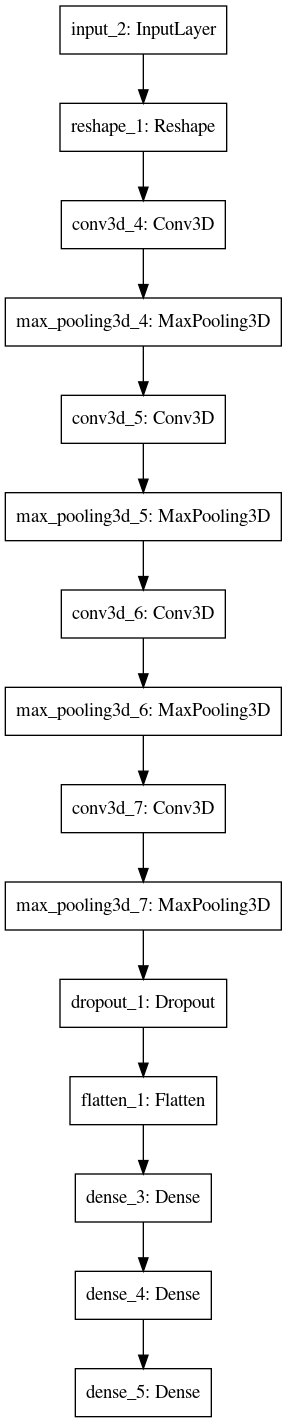

In [5]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

display(Image(filename="./model/cnn.png"))

In [7]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=10, batch_size=512, shuffle=True, verbose=2, callbacks=[es])


Epoch 1/10
22/22 - 97s - loss: 0.8684 - accuracy: 0.6658 - val_loss: 0.9026 - val_accuracy: 0.6259
Epoch 2/10
22/22 - 99s - loss: 0.8409 - accuracy: 0.6659 - val_loss: 0.8776 - val_accuracy: 0.6259
Epoch 3/10
22/22 - 99s - loss: 0.8054 - accuracy: 0.6747 - val_loss: 0.9794 - val_accuracy: 0.6296
Epoch 4/10
22/22 - 100s - loss: 0.7280 - accuracy: 0.7020 - val_loss: 0.8755 - val_accuracy: 0.5930
Epoch 5/10
22/22 - 98s - loss: 0.5795 - accuracy: 0.7661 - val_loss: 0.9435 - val_accuracy: 0.5366
Epoch 6/10
22/22 - 97s - loss: 0.4077 - accuracy: 0.8388 - val_loss: 1.1406 - val_accuracy: 0.4967
Epoch 7/10
22/22 - 99s - loss: 0.3062 - accuracy: 0.8851 - val_loss: 1.4564 - val_accuracy: 0.4588
Epoch 8/10
22/22 - 99s - loss: 0.2241 - accuracy: 0.9162 - val_loss: 1.8326 - val_accuracy: 0.4498
Epoch 9/10
22/22 - 99s - loss: 0.1685 - accuracy: 0.9353 - val_loss: 1.9645 - val_accuracy: 0.4650
Epoch 10/10
22/22 - 99s - loss: 0.1641 - accuracy: 0.9333 - val_loss: 2.5323 - val_accuracy: 0.4609


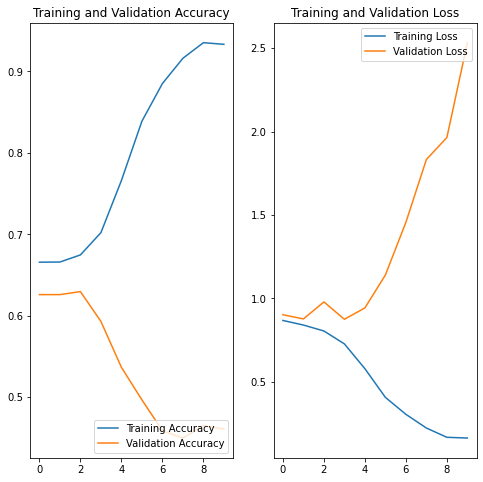

In [64]:
epochs = 10
# Evaluation 
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

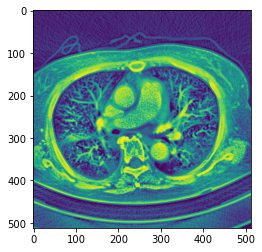

In [79]:
from PIL import Image
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
img_path = '../Code/benchmark_liver_tumor/train/train/SN00017916/SN00017916_1.png'
data = mpimg.imread(img_path)
pic = plt.imshow(data)

from keras.preprocessing import image
img = image.load_img(img_path, target_size=(32,32))

x = image.img_to_array(img)


In [81]:
x.shape

(32, 32, 3)

In [83]:
cnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 5)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 5, 1)      0         
_________________________________________________________________
conv3d (Conv3D)              (None, 32, 32, 5, 16)     144       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 16, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 5, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 8, 5, 16)      